In [180]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [181]:
import os
results = np.load('/Users/sean/Desktop/college/intern/2D Wall/2D_Wall_NoProp.npy') #for mac

In [182]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.05

width = 5   # m
depth = 8   # m
t = 0.1     # m
D =  E * t**3 / (12 * (1 - nu**2))

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

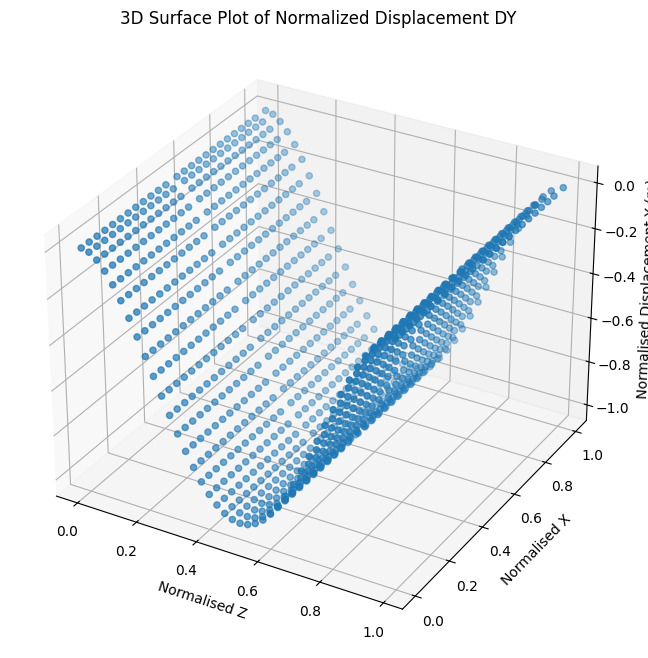

In [183]:
x_raw, z_raw, y_raw = np.split(results, 3, axis = -1)

zdim_raw, xdim_raw = x_raw.shape[:2]
zdim, xdim = 40, 25
z_sample_index = np.linspace(0, zdim_raw-1, zdim, dtype=int)
x_sample_index = np.linspace(0, xdim_raw-1, xdim, dtype=int)

# Use meshgrid to create 2D indexing arrays
z_sample_mesh, x_sample_mesh = np.meshgrid(z_sample_index, x_sample_index, indexing='ij')

z_sampled_raw = z_raw[z_sample_mesh, x_sample_mesh]
x_sampled_raw = x_raw[z_sample_mesh, x_sample_mesh]
y_sampled_raw = y_raw[z_sample_mesh, x_sample_mesh]

z_max = np.max(z_raw[:,0])
x_max = np.max(x_raw[0])
y_max = np.max(abs(y_raw))

z_flatten = z_sampled_raw.flatten()
x_flatten = x_sampled_raw.flatten()
y_flatten = y_sampled_raw.flatten()

z_norm = z_sampled_raw / depth
x_norm = x_sampled_raw / width
y_norm = y_sampled_raw / y_max

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

z_norm = np.squeeze(z_norm, -1)
x_norm = np.squeeze(x_norm, -1)
y_norm = np.squeeze(y_norm, -1)

z_norm_flatten = z_norm.flatten()
x_norm_flatten = x_norm.flatten()
y_norm_flatten = y_norm.flatten()

results_norm_flatten = np.stack((z_norm_flatten, x_norm_flatten, y_norm_flatten), axis = -1)
# Create a scatter plot
surf = ax.scatter(z_norm_flatten, x_norm_flatten, y_norm_flatten)
# Add labels and title
ax.set_xlabel('Normalised Z')
ax.set_ylabel('Normalised X')
ax.set_zlabel('Normalised Displacement Y (m)')
ax.set_title('3D Surface Plot of Normalized Displacement DY')

plt.show()

In [184]:
def q_soil_smooth(z, width=0.2):

    # Lines on either side of the break
    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)
    
q_true = q_soil_smooth(z_flatten)
q_max = max(q_true)
q_norm = q_true / q_max


In [185]:
import tensorflow as tf
from tensorflow import keras

In [186]:
model = keras.Sequential([
    keras.layers.Input(shape = (2,)),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)


physics loss

In [188]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 + dx2


def first_order_grad(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = model(inputs)
    g = tape.gradient(f, inputs)
    return g

In [189]:
def piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf):  #input normalized
    z_phys = z_norm_flatten_tf * z_max
    q_total = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    return q_total

In [190]:
N_DATA_ONLY_EPOCHS = 2000
N_BC_EPOCHS = 2000
N_PHYSICS_EPOCHS = 1000

@tf.function

def train_step(batch, epoch_val):
  z, x , y_true = batch[:,0], batch[:,1], batch[:,2]

  with tf.GradientTape() as tape:
    zxstack = tf.stack((z, x), axis = -1)
    y_pred = model(zxstack)
    y_pred = tf.squeeze(y_pred, -1)  # Ensure y_pred is 1D
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    gradz, gradx = tf.unstack(first_order_grad(zxstack), axis = -1)
    bc_disp = tf.reduce_mean(tf.square(y_pred[:xdim]) + tf.square(y_pred[-xdim:]))
    bc_z_loss = 0#tf.reduce_mean(tf.square(gradz[:xdim]) + tf.square(gradz[-xdim:]))
    bc_x_boundaries = 0#tf.square([gradx[i] for i in range(z.shape[0]) if i % xdim ==0 or (i+1) % xdim == 0])
    bc_x_loss = 0#tf.reduce_sum(bc_x_boundaries) 
    bc_loss = bc_disp + bc_z_loss + bc_x_loss
      
    biharmonic = laplacian(tf.stack((z,x), axis = -1), laplacian)
    q_pred = piecewise_q(z,x)
    physics_residual = tf.square(biharmonic * D * y_max / q_max - q_pred / q_max)
    physics_loss = tf.reduce_mean(physics_residual)

    if epoch_val < N_DATA_ONLY_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.1, 0.0
    elif epoch_val < N_BC_EPOCHS:
        w_data, w_phys, w_bc = 0.2, 1.0, 0.2
    else:
        w_data, w_phys, w_bc = 0.2, 1.0, 0.5
        
    loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

  variables = model.trainable_variables + [m_a, m_p]
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del tape
  return loss, data_loss, bc_loss, physics_loss

In [191]:
def snapshot(model):
    snap = keras.models.clone_model(model)
    snap.build(model.input_shape)
    snap.set_weights(model.get_weights())
    return snap

In [ ]:
# --- 0. batching parameters --------------------------------------------
BATCH_SIZE  = 1024
SHUFFLE_BUF = 10_000

model_phase1, model_phase2 = model, model

dataset = (tf.data.Dataset.from_tensor_slices(
              tf.convert_to_tensor(results_norm_flatten, dtype=tf.float32))
           .shuffle(SHUFFLE_BUF, reshuffle_each_iteration=True)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

# --- 1. history containers ---------------------------------------------
history        = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_params = {"m_a": [], "m_p": []}

# --- 2. training loop ---------------------------------------------------
for epoch in range(5000):
    # We’ll keep the metrics from the *last* batch in this epoch
    for batch in dataset:
        loss, data_l, bc_l, phys_l = train_step(batch, tf.cast(epoch, tf.int32))

    # record those metrics (no division → no ZeroDivisionError)
    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | "
              f"loss {loss.numpy():.3e} | "
              f"data {data_l.numpy():.3e} | "
              f"bc {bc_l.numpy():.3e} | "
              f"phys {phys_l.numpy():.3e}")
    
    if epoch == N_DATA_ONLY_EPOCHS - 1:
        model_phase1 = snapshot(model)
    if epoch == N_DATA_ONLY_EPOCHS + N_BC_EPOCHS - 1:
        model_phase2 = snapshot(model)
model_final = model


Epoch   0 | loss 6.098e-01 | data 4.084e-01 | bc 5.503e-04 | phys 2.014e+00
Epoch   5 | loss 4.977e-01 | data 3.000e-01 | bc 2.043e-02 | phys 1.977e+00
Epoch  10 | loss 3.943e-01 | data 2.007e-01 | bc 1.146e-01 | phys 1.936e+00
Epoch  15 | loss 3.244e-01 | data 1.363e-01 | bc 4.382e-01 | phys 1.881e+00
Epoch  20 | loss 3.356e-01 | data 1.552e-01 | bc 9.265e-01 | phys 1.805e+00
Epoch  25 | loss 3.159e-01 | data 1.406e-01 | bc 7.507e-01 | phys 1.754e+00
Epoch  30 | loss 3.031e-01 | data 1.313e-01 | bc 4.808e-01 | phys 1.718e+00
Epoch  35 | loss 3.001e-01 | data 1.328e-01 | bc 4.396e-01 | phys 1.672e+00
Epoch  40 | loss 2.912e-01 | data 1.298e-01 | bc 4.475e-01 | phys 1.614e+00
Epoch  45 | loss 2.846e-01 | data 1.288e-01 | bc 6.021e-01 | phys 1.558e+00
Epoch  50 | loss 2.809e-01 | data 1.293e-01 | bc 6.104e-01 | phys 1.516e+00
Epoch  55 | loss 2.751e-01 | data 1.274e-01 | bc 5.330e-01 | phys 1.476e+00
Epoch  60 | loss 2.701e-01 | data 1.272e-01 | bc 5.344e-01 | phys 1.429e+00
Epoch  65 | 

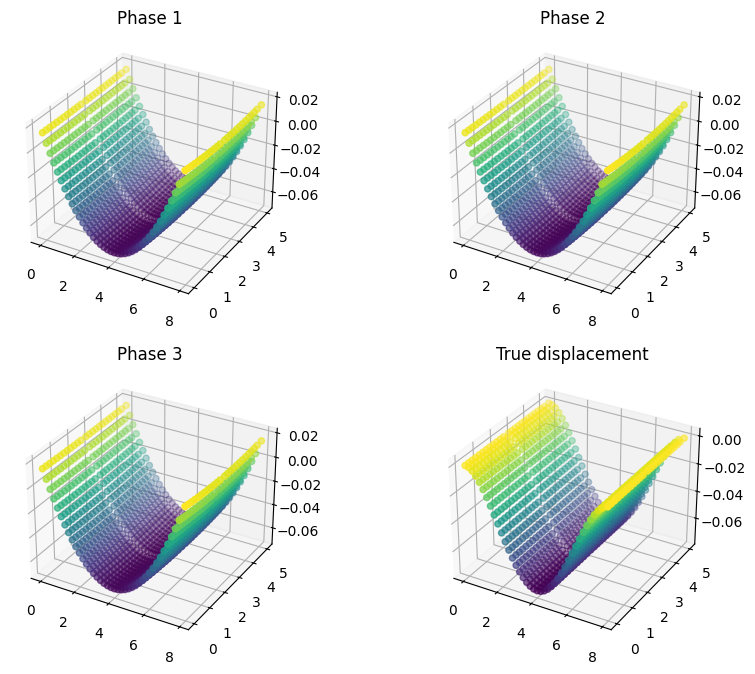

In [ ]:
z_norm_flatten_tf = tf.convert_to_tensor(z_norm_flatten, dtype=tf.float32)
x_norm_flatten_tf = tf.convert_to_tensor(x_norm_flatten, dtype=tf.float32)

zxstack = tf.stack((z_norm_flatten_tf, x_norm_flatten_tf), axis = -1)

y_pred_norm1 = model_phase1(zxstack)
y_pred_norm1 = np.squeeze(y_pred_norm1, -1)
y_pred1 = y_pred_norm1 * y_max

y_pred_norm2 = model_phase2(zxstack)
y_pred_norm2 = np.squeeze(y_pred_norm2, -1)
y_pred2 = y_pred_norm2 * y_max

y_pred_norm3 = model(zxstack)
y_pred_norm3 = np.squeeze(y_pred_norm3, -1)
y_pred3 = y_pred_norm3 * y_max

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(z_flatten, x_flatten, y_pred1, c = y_pred1, cmap = 'viridis')
ax1.set_title('Phase 1')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(z_flatten, x_flatten, y_pred2, c = y_pred2, cmap='viridis')
ax2.set_title('Phase 2')

ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten, x_flatten, y_pred3, c = y_pred3, cmap = 'viridis')
ax3.set_title('Phase 3')

ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten, x_flatten, y_sampled_raw, c = y_sampled_raw, cmap = 'viridis')
ax4.set_title('True displacement')

plt.show()

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


Text(0.5, 0.92, 'predicted loading from variables')

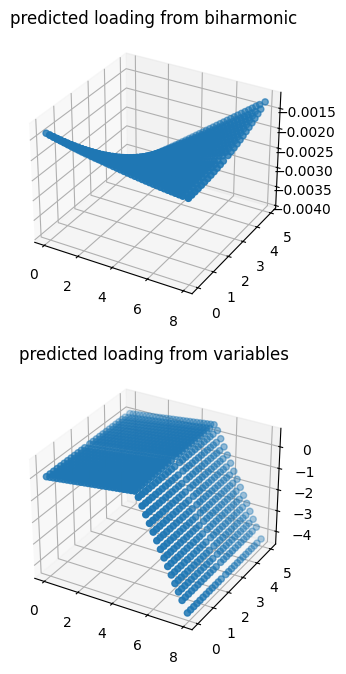

In [ ]:
bih = laplacian(zxstack, laplacian)

cut = 0
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211, projection = '3d')
ax1.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], bih[cut*xdim:])
ax1.set_title('predicted loading from biharmonic')

print(m_a, m_p)

q_params = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf)
ax1 = fig.add_subplot(212, projection = '3d')
ax1.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_params[cut*xdim:]/q_max)
ax1.set_title('predicted loading from variables')

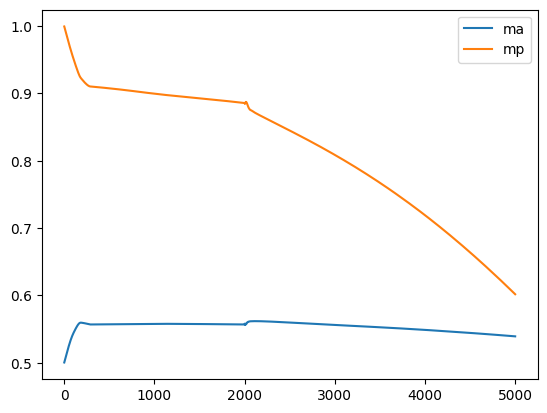

In [ ]:
epoch_plot = np.arange(len(history_params["m_a"]))
plt.plot(epoch_plot, history_params["m_a"], label='ma')
plt.plot(epoch_plot, history_params["m_p"], label='mp')
plt.legend()